## Изучение данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/Churn.csv', index_col=0).reset_index(drop=True)

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


In [5]:
df.isna().mean()

CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


У нас есть датафрейм на 10 000 строк и 13 колонок (был еще лишний столбец 'RowNumber', но я его сразу же удалил).  
Скорее всего колонка 'CustomerId' нам тоже не понадобится, но это надо проверить.  
Наименования столбцов содержат верхний регистр и есть пропуски в колонке 'Tenure'. Дубликатов нет, все колонки имеют соответствующий тип данных. Но для машинного обучения необходимо разбить категориальные колонки 'Surname', 'Geography' и 'Gender' методом порядкового кодирования (т.к. OHE создаст около тысячи новых признаков) и привести все колонки (кроме целевой 'Exited') к единому масштабу.

## Исследование задачи

In [8]:
df = df.rename(columns=lambda x: re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower())
df.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [9]:
df['customer_id'].nunique()

10000

In [10]:
df = df.drop(['customer_id', 'surname'], axis=1)

In [11]:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [12]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [13]:
df['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

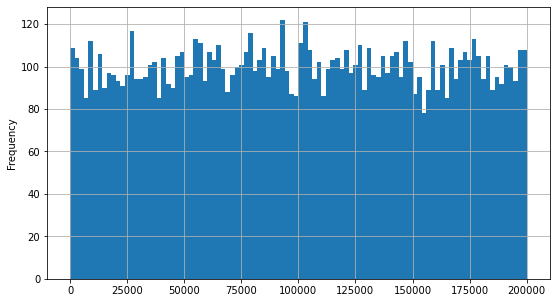

In [14]:
df['estimated_salary'].plot(kind='hist', bins=100, grid=True, figsize=(9, 5));

Странно выглядят значения предполагаемой зарплаты 11.58. Но эти значения не выбиваются из общей массы. Скорее всего ничего не буду с этим делать.

In [15]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

<AxesSubplot:>

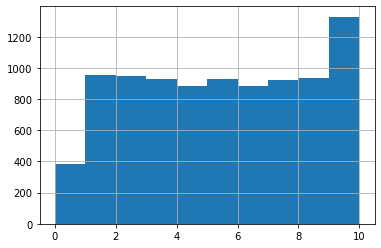

In [16]:
df['tenure'].hist()

Функция заполняет пропуски медианой, сгруппированной по возрасту и количеству продуктов банка. А после заполняет пропуски тех наблюдений, которые не попали ни в одну группу.

In [17]:
def fill_na(data, column):
    print('Медиана до заполнения пропусков:', data[column].median())
    data[column] = data.groupby(['age', 'num_of_products'])[column].transform(lambda x: x.fillna(x.median())).copy()
    data[column] = data[column].fillna(data[column].median()).copy()
    print('Медиана после заполнения пропусков:', data[column].median())
    
    return data[column]

In [18]:
df['tenure'] = fill_na(df, 'tenure')

Медиана до заполнения пропусков: 5.0
Медиана после заполнения пропусков: 5.0


In [19]:
df['tenure'].describe()

count    10000.000000
mean         4.992850
std          2.766142
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64

<AxesSubplot:>

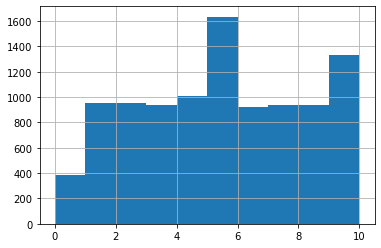

In [20]:
df['tenure'].hist()

In [21]:
encoder = OrdinalEncoder()
df[['geography',
    'gender',
    'tenure']] = pd.DataFrame(encoder.fit_transform(df[['geography', 'gender', 'tenure']]),
                              columns=['geography', 'gender', 'tenure'])

In [22]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,12.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


In [23]:
df.drop('exited', axis=1).corr().style.background_gradient(cmap='Reds')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
credit_score,1.000000,0.007888,-0.002857,-0.003965,-0.000560,0.006268,0.012238,-0.005458,0.025651,-0.001384
geography,0.007888,1.000000,0.004719,0.022812,-0.001960,0.069408,0.003972,-0.008523,0.006724,-0.001369
gender,-0.002857,0.004719,1.000000,-0.027544,0.011424,0.012087,-0.021859,0.005766,0.022544,-0.008112
age,-0.003965,0.022812,-0.027544,1.000000,-0.011594,0.028308,-0.030680,-0.011721,0.085472,-0.007201
tenure,-0.000560,-0.001960,0.011424,-0.011594,1.000000,-0.007066,0.010224,0.023702,-0.030563,0.010405
balance,0.006268,0.069408,0.012087,0.028308,-0.007066,1.000000,-0.304180,-0.014858,-0.010084,0.012797
num_of_products,0.012238,0.003972,-0.021859,-0.030680,0.010224,-0.304180,1.000000,0.003183,0.009612,0.014204
has_cr_card,-0.005458,-0.008523,0.005766,-0.011721,0.023702,-0.014858,0.003183,1.000000,-0.011866,-0.009933
is_active_member,0.025651,0.006724,0.022544,0.085472,-0.030563,-0.010084,0.009612,-0.011866,1.000000,-0.011421
estimated_salary,-0.001384,-0.001369,-0.008112,-0.007201,0.010405,0.012797,0.014204,-0.009933,-0.011421,1.000000


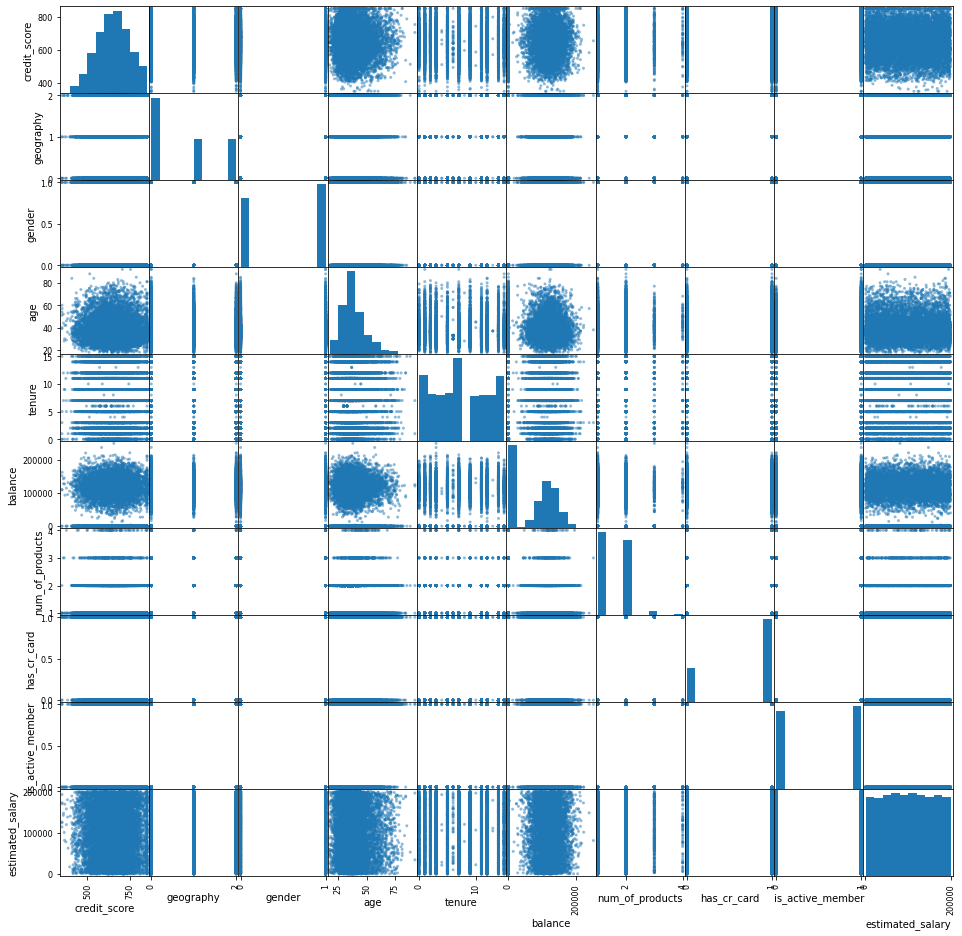

In [24]:
pd.plotting.scatter_matrix(df.drop('exited', axis=1), figsize=(16, 16));

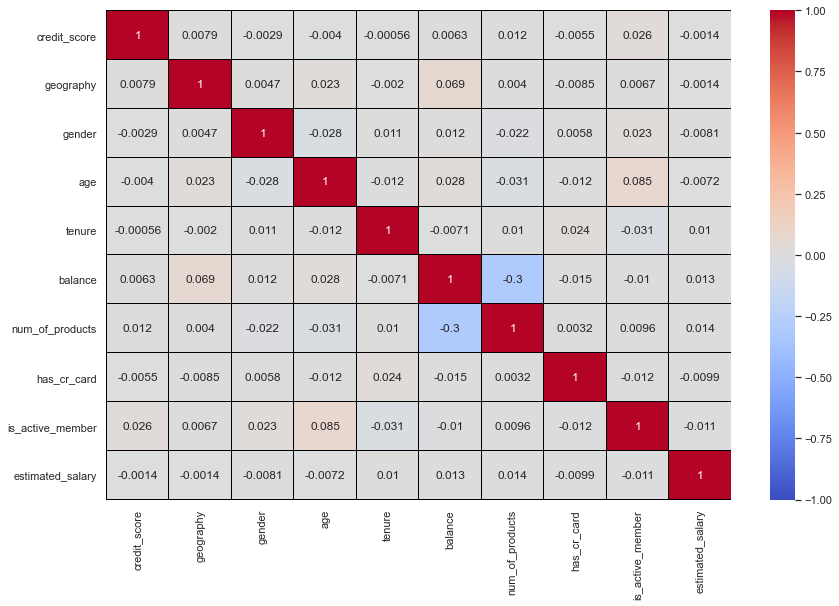

In [25]:
sns.set(rc={'figure.figsize':(14, 9)})
sns.heatmap(df.drop('exited', axis=1).corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap='coolwarm',
            linewidths=.01,
            linecolor='black');

In [26]:
X = df.drop('exited', axis=1)
y = df['exited']

In [27]:
X.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58
2,502,0.0,0.0,42,12.0,159660.80,3,1,0,113931.57
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
len(df)

10000

In [30]:
len(X_train)

8000

In [31]:
len(X_test)

2000

In [32]:
len(X_train) + len(X_test)

10000

In [33]:
len(X_train) + len(X_test) == len(y_train) + len(y_test)

True

In [34]:
y.mean()

0.2037

In [35]:
y_train.mean()

0.20375

In [36]:
y_test.mean()

0.2035

#### Дерево решений

In [37]:
pipe_dt = Pipeline([('sc', StandardScaler()),
                    ('clf_dt', DecisionTreeClassifier(random_state=42))])
parameters = {'clf_dt__criterion': ['gini', 'entropy'],
              'clf_dt__max_depth': range(1, 21),
              'clf_dt__min_samples_split': range(2, 21, 5),
              'clf_dt__min_samples_leaf': range(1, 21, 5)}

In [38]:
grid_search_cv_dt = GridSearchCV(pipe_dt,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [39]:
grid_search_cv_dt.best_params_

{'clf_dt__criterion': 'entropy',
 'clf_dt__max_depth': 9,
 'clf_dt__min_samples_leaf': 11,
 'clf_dt__min_samples_split': 2}

In [40]:
best_clf_dt_disbalance = grid_search_cv_dt.best_estimator_

In [41]:
predictions_dt_train_disbalance = best_clf_dt_disbalance.predict(X_train)

In [42]:
f1_score(y_train, predictions_dt_train_disbalance)

0.6211085801063022

In [43]:
roc_auc_score(y_train, predictions_dt_train_disbalance)

0.7363205593705155

#### Случайный лес

In [44]:
pipe_rf = Pipeline([('sc', StandardScaler()),
                    ('clf_rf', RandomForestClassifier(warm_start=True, random_state=42))])
parameters = {'clf_rf__n_estimators': [50],
              'clf_rf__max_depth': range(1, 21),
              'clf_rf__min_samples_split': range(2, 21, 5),
              'clf_rf__min_samples_leaf': range(1, 21, 5)}

In [45]:
grid_search_cv_rf = GridSearchCV(pipe_rf,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [46]:
grid_search_cv_rf.best_params_

{'clf_rf__max_depth': 18,
 'clf_rf__min_samples_leaf': 1,
 'clf_rf__min_samples_split': 12,
 'clf_rf__n_estimators': 50}

In [47]:
best_clf_rf_disbalance = grid_search_cv_rf.best_estimator_

In [48]:
predictions_rf_train_disbalance = best_clf_rf_disbalance.predict(X_train)

In [49]:
f1_score(y_train, predictions_rf_train_disbalance)

0.7746376811594202

In [50]:
roc_auc_score(y_train, predictions_rf_train_disbalance)

0.8231260413556645

#### Логистическая регрессия

In [51]:
pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('clf_lr', LogisticRegression(solver='lbfgs', random_state=42))])
parameters = {}
grid_search_cv_lr = GridSearchCV(pipe_lr,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [52]:
best_clf_lr_disbalance = grid_search_cv_lr.best_estimator_

In [53]:
predictions_lr_train_disbalance = best_clf_lr_disbalance.predict(X_train)

In [54]:
f1_score(y_train, predictions_lr_train_disbalance)

0.2686993806574559

In [55]:
roc_auc_score(y_train, predictions_lr_train_disbalance)

0.5718248885207693

Перевел названия столбцов в нижний регистр и snake_case, проверил на мультиколлинеарность: по этому принципу все признаки можно оставить. При этом удалил колонки 'customer_id' и 'surname' за ненадобностью, заполнил пропуски в колонке 'tenure', преобразовал категориальные признаки методом порядкового кодирования, разбил датасет на обучающие признаки и вектор, привел к общему масштабу обучающие признаки (в пайплайнах).  
Обучил случайный лес, дерево решений и логистическую регрессию без учета дисбаланса. Дисбаланс сильно влияет на качество предсказания. Исправим это.

## Борьба с дисбалансом

### Коррекция весов

#### Дерево решений

In [56]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'clf_dt__class_weight': [{0: n, 1: 1.0 - n} for n in weights]}

In [57]:
grid_search_cv_dt = GridSearchCV(pipe_dt,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [58]:
grid_search_cv_dt.best_params_

{'clf_dt__class_weight': {0: 0.5920100502512563, 1: 0.4079899497487437}}

In [59]:
parameters = {'clf_dt__criterion': ['gini', 'entropy'],
              'clf_dt__max_depth': range(1, 21),
              'clf_dt__min_samples_split': range(2, 21, 5),
              'clf_dt__min_samples_leaf': range(1, 21, 5),
              'clf_dt__class_weight': [{0: list(grid_search_cv_dt.best_params_.values())[0][0],
                                        1: list(grid_search_cv_dt.best_params_.values())[0][1]}]}

In [60]:
grid_search_cv_dt = GridSearchCV(pipe_dt,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [61]:
grid_search_cv_dt.best_params_

{'clf_dt__class_weight': {0: 0.5920100502512563, 1: 0.4079899497487437},
 'clf_dt__criterion': 'entropy',
 'clf_dt__max_depth': 14,
 'clf_dt__min_samples_leaf': 11,
 'clf_dt__min_samples_split': 2}

In [62]:
best_clf_dt_balance_wgt = grid_search_cv_dt.best_estimator_

In [63]:
predictions_dt_train_balance_wgt = best_clf_dt_balance_wgt.predict(X_train)

In [64]:
f1_score(y_train, predictions_dt_train_balance_wgt)

0.6671619613670134

In [65]:
roc_auc_score(y_train, predictions_dt_train_balance_wgt)

0.7625872812551164

#### Случайный лес

In [66]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'clf_rf__class_weight': [{0: n, 1: 1.0 - n} for n in weights]}

In [67]:
grid_search_cv_rf = GridSearchCV(pipe_rf,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [68]:
grid_search_cv_rf.best_params_

{'clf_rf__class_weight': {0: 0.9303015075376885, 1: 0.06969849246231152}}

In [69]:
parameters = {'clf_rf__n_estimators': [50],
              'clf_rf__max_depth': range(1, 21),
              'clf_rf__min_samples_split': range(2, 21, 5),
              'clf_rf__min_samples_leaf': range(1, 21, 5),
              'clf_rf__class_weight': [{0: list(grid_search_cv_rf.best_params_.values())[0][0],
                                        1: list(grid_search_cv_rf.best_params_.values())[0][1]}]}

In [70]:
grid_search_cv_rf = GridSearchCV(pipe_rf,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [71]:
grid_search_cv_rf.best_params_

{'clf_rf__class_weight': {0: 0.9303015075376885, 1: 0.06969849246231152},
 'clf_rf__max_depth': 20,
 'clf_rf__min_samples_leaf': 1,
 'clf_rf__min_samples_split': 2,
 'clf_rf__n_estimators': 50}

In [72]:
best_clf_rf_balance_wgt = grid_search_cv_rf.best_estimator_

In [73]:
predictions_rf_train_balance_wgt = best_clf_rf_balance_wgt.predict(X_train)

In [74]:
f1_score(y_train, predictions_rf_train_balance_wgt)

0.9670468948035489

In [75]:
roc_auc_score(y_train, predictions_rf_train_balance_wgt)

0.9680981595092024

#### Логистическая регрессия

In [76]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'clf_lr__class_weight': [{0: n, 1: 1.0 - n} for n in weights]}

In [77]:
grid_search_cv_lr = GridSearchCV(pipe_lr,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [78]:
grid_search_cv_lr.best_params_

{'clf_lr__class_weight': {0: 0.22884422110552766, 1: 0.7711557788944723}}

In [79]:
parameters = {'clf_lr__class_weight': [{0: list(grid_search_cv_lr.best_params_.values())[0][0],
                                        1: list(grid_search_cv_lr.best_params_.values())[0][1]}]}

In [80]:
grid_search_cv_lr = GridSearchCV(pipe_lr,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [81]:
best_clf_lr_balance_wgt = grid_search_cv_lr.best_estimator_

In [82]:
predictions_lr_train_balance_wgt = best_clf_lr_balance_wgt.predict(X_train)

In [83]:
f1_score(y_train, predictions_lr_train_balance_wgt)

0.4876425855513308

In [84]:
roc_auc_score(y_train, predictions_lr_train_balance_wgt)

0.6929028902736176

### Oversamling

#### Дерево решений

In [85]:
imb_pipe_dt = make_pipeline(StandardScaler(),
                            SMOTE(random_state=42),
                            DecisionTreeClassifier(random_state=42))
parameters = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
              'decisiontreeclassifier__max_depth': range(1, 21),
              'decisiontreeclassifier__min_samples_split': range(2, 21, 5),
              'decisiontreeclassifier__min_samples_leaf': range(1, 21, 5)}

In [86]:
grid_search_cv_dt = GridSearchCV(imb_pipe_dt,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [87]:
grid_search_cv_dt.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 10,
 'decisiontreeclassifier__min_samples_leaf': 11,
 'decisiontreeclassifier__min_samples_split': 2}

In [88]:
best_clf_dt_balance_ups = grid_search_cv_dt.best_estimator_

In [89]:
predictions_dt_train_balance_ups = best_clf_dt_balance_ups.predict(X_train)

In [90]:
f1_score(y_train, predictions_dt_train_balance_ups)

0.6529395827688973

In [91]:
roc_auc_score(y_train, predictions_dt_train_balance_ups)

0.8024419489362522

#### Случайный лес

In [92]:
imb_pipe_rf = make_pipeline(StandardScaler(),
                            SMOTE(random_state=42),
                            RandomForestClassifier(warm_start=True, random_state=42))

In [93]:
parameters = {'randomforestclassifier__n_estimators': [50],
              'randomforestclassifier__max_depth': range(1, 21),
              'randomforestclassifier__min_samples_split': range(2, 21, 5),
              'randomforestclassifier__min_samples_leaf': range(1, 21, 5)}

In [94]:
grid_search_cv_rf = GridSearchCV(imb_pipe_rf,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [95]:
grid_search_cv_rf.best_params_

{'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__min_samples_leaf': 6,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50}

In [96]:
best_clf_rf_balance_ups = grid_search_cv_rf.best_estimator_

In [97]:
predictions_rf_train_balance_ups = best_clf_rf_balance_ups.predict(X_train)

In [98]:
f1_score(y_train, predictions_rf_train_balance_ups)

0.7844852726742492

In [99]:
roc_auc_score(y_train, predictions_rf_train_balance_ups)

0.8769408943379144

#### Логистическая регрессия

In [100]:
imb_pipe_lr = make_pipeline(StandardScaler(),
                            SMOTE(random_state=42),
                            LogisticRegression(solver='lbfgs', random_state=42))
parameters = {}

In [101]:
grid_search_cv_lr = GridSearchCV(imb_pipe_lr,
                                 parameters,
                                 scoring=['f1', 'roc_auc'],
                                 refit='f1',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [102]:
best_clf_lr_balance_ups = grid_search_cv_lr.best_estimator_

In [103]:
predictions_lr_train_balance_ups = best_clf_lr_balance_ups.predict(X_train)

In [104]:
f1_score(y_train, predictions_lr_train_balance_ups)

0.4812294182217344

In [105]:
roc_auc_score(y_train, predictions_lr_train_balance_ups)

0.69263273974054

## Тестирование моделей

#### Дерево решений

In [106]:
predictions_dt_test_disbalance = best_clf_dt_disbalance.predict(X_test)

In [107]:
f1_score(y_test, predictions_dt_test_disbalance)

0.5471406491499227

In [108]:
roc_auc_score(y_test, predictions_dt_test_disbalance)

0.6976707061452824

In [109]:
predictions_dt_test_balance_wgt = best_clf_dt_balance_wgt.predict(X_test)

In [110]:
f1_score(y_test, predictions_dt_test_balance_wgt)

0.5151515151515151

In [111]:
roc_auc_score(y_test, predictions_dt_test_balance_wgt)

0.6827937336411913

In [112]:
predictions_dt_test_balance_ups = best_clf_dt_balance_ups.predict(X_test)

In [113]:
f1_score(y_test, predictions_dt_test_balance_ups)

0.5589519650655022

In [114]:
roc_auc_score(y_test, predictions_dt_test_balance_ups)

0.7350863961033453

#### Случайный лес

In [115]:
predictions_rf_test_disbalance = best_clf_rf_disbalance.predict(X_test)

In [116]:
f1_score(y_test, predictions_rf_test_disbalance)

0.578538102643857

In [117]:
roc_auc_score(y_test, predictions_rf_test_disbalance)

0.7128075687397721

In [118]:
predictions_rf_test_balance_wgt = best_clf_rf_balance_wgt.predict(X_test)

In [119]:
f1_score(y_test, predictions_rf_test_balance_wgt)

0.5830815709969789

In [120]:
roc_auc_score(y_test, predictions_rf_test_balance_wgt)

0.7176405989965313

In [121]:
predictions_rf_test_balance_ups = best_clf_rf_balance_ups.predict(X_test)

In [122]:
f1_score(y_test, predictions_rf_test_balance_ups)

0.6089965397923877

In [123]:
roc_auc_score(y_test, predictions_rf_test_balance_ups)

0.7628051780594154

#### Логистическая регрессия

In [124]:
probabilities_valid = best_clf_lr_disbalance.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = 0
auc_roc = 0
thresh = 0
for threshold in np.arange(0, 1, 0.02):
    predicted = probabilities_one_valid > threshold
    res = f1_score(y_test, predicted)
    auc_roc = roc_auc_score(y_test, predicted)
    if res > f1:
        f1 = res
        thresh = threshold
print("Порог = {:.2f}, F1-мера = {:.3f}, AUC-ROC = {:.3f}".format(thresh, f1, auc_roc))

Порог = 0.26, F1-мера = 0.498, AUC-ROC = 0.500


In [125]:
probabilities_valid = best_clf_lr_balance_wgt.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = 0
auc_roc = 0
thresh = 0
for threshold in np.arange(0, 1, 0.02):
    predicted = probabilities_one_valid > threshold
    res = f1_score(y_test, predicted)
    auc_roc = roc_auc_score(y_test, predicted)
    if res > f1:
        f1 = res
        thresh = threshold
print("Порог = {:.2f}, F1-мера = {:.3f}, AUC-ROC = {:.3f}".format(thresh, f1, auc_roc))

Порог = 0.54, F1-мера = 0.502, AUC-ROC = 0.500


In [126]:
probabilities_valid = best_clf_lr_balance_ups.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = 0
auc_roc = 0
thresh = 0
for threshold in np.arange(0, 1, 0.02):
    predicted = probabilities_one_valid > threshold
    res = f1_score(y_test, predicted)
    auc_roc = roc_auc_score(y_test, predicted)
    if res > f1:
        f1 = res
        thresh = threshold
print("Порог = {:.2f}, F1-мера = {:.3f}, AUC-ROC = {:.3f}".format(thresh, f1, auc_roc))

Порог = 0.50, F1-мера = 0.503, AUC-ROC = 0.500


## Вывод

##### F1-метрика
**Дерево решений**
+ дисбаланс 0.5471406491499227
+ коррекция весов 0.5151515151515151
+ оверемплинг 0.5589519650655022

**Случайный лес**
+ дисбаланс 0.578538102643857
+ коррекция весов 0.5830815709969789
+ апсемплинг 0.6089965397923877

**Логистическая регрессия**
+ дисбаланс 0.498
+ коррекция весов 0.502
+ апсемплинг 0.503

Лучшей моделью оказался случайный лес, обученный на данных, к которым был применен оверсемплинг. Метрика AUC-ROC для него составляет 0.7628051780594154

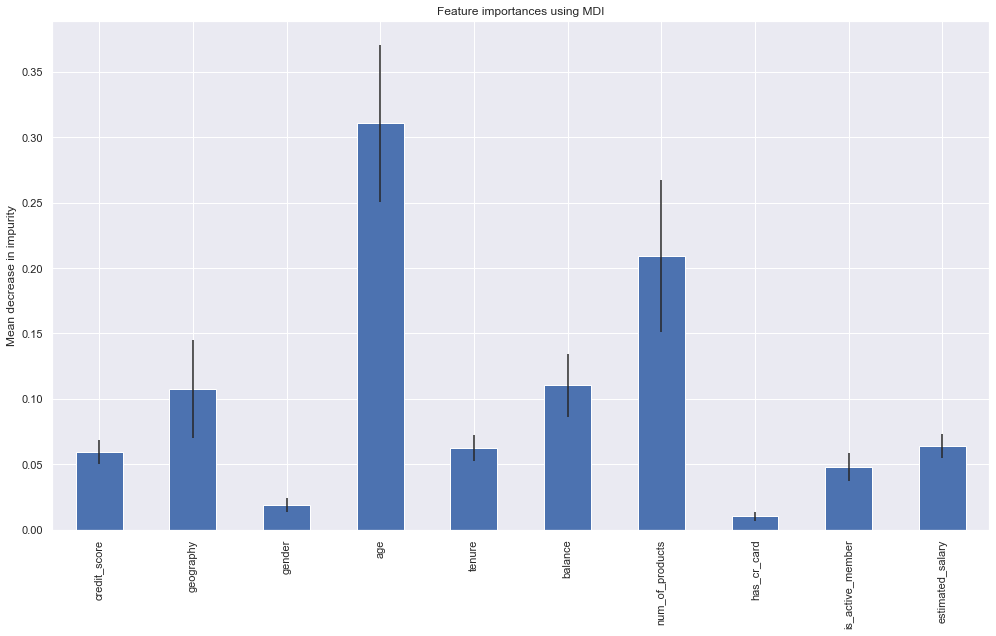

In [127]:
importances = best_clf_rf_balance_ups.steps[2][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_clf_rf_balance_ups.steps[2][1].estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

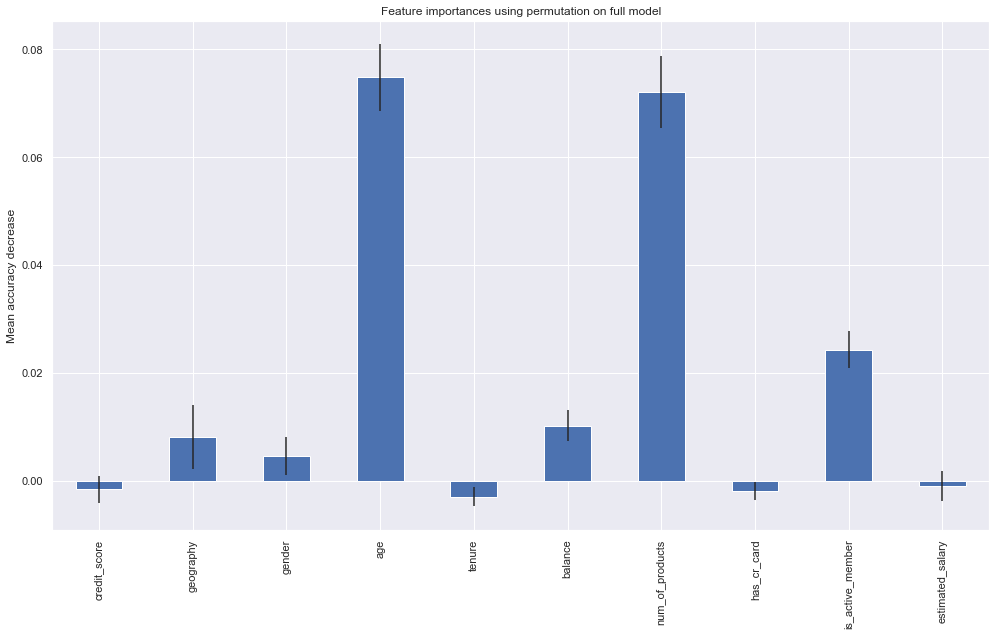

In [128]:
result = permutation_importance(best_clf_rf_balance_ups,
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=list(X.columns))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Больше всего на отток клиента влияют возраст и количество продуктов в банке.